In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### data loading and preparation

In [3]:
import concord as ccd
import scanpy as sc
import torch
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
import time
from pathlib import Path
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
seed = 0

/home/ec2-user/miniforge3/envs/concord/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
proj_name = "cel_packerN2_downsample"
file_name = "cel_packerN2_downsample"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0
ccd.ul.set_seed(seed)
save_dir = Path(f"../save/{proj_name}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)


In [5]:
adata = sc.read_h5ad(Path('../data/CBCEcombineN2/') / 'adata_celsub_Jun26-1610.h5ad')
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=10000, subset=False)
sc.tl.pca(adata, n_comps=300, svd_solver='arpack', use_highly_variable=True)
adata = adata[:, adata.var.highly_variable].copy()
adata.write_h5ad(data_dir / f"{file_name}_preprocessed.h5ad")
print(f"✅ Preprocessed data saved to {data_dir / f'{file_name}_preprocessed.h5ad'}")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


✅ Preprocessed data saved to ../data/cel_packerN2_downsample/cel_packerN2_downsample_preprocessed.h5ad


In [5]:
DATA_FILE     = Path(f"{file_name}_preprocessed.h5ad")
adata = sc.read_h5ad(data_dir / DATA_FILE)

### Create jobs

In [6]:
import json, math, subprocess
from pathlib import Path
import numpy as np

fractions = [1.0, 0.5, 0.25, 0.1, 0.05, 0.01]
concord_args = {
    "latent_dim": 100,
    "batch_size": 256,
    "encoder_dims": [1000],
    "p_intra_domain": 1.0,
    "augmentation_mask_prob": 0.30,
    "clr_temperature": 0.30,
    "sampler_knn": 1000,
    "n_epochs": 15,        # gets overwritten below
    "lr":       1e-2,   # gets overwritten below
}

py_methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
output_dir = '../jobs'
device = 'auto'
conda_env = 'concord'
batch_key = 'batch'
state_key = 'None'
latent_dim = '100'  # Adjust as needed, but should match the encoder_dims in concord_args

rng  = np.random.default_rng(seed)
for frac in fractions:
    tag       = f"ds{int(frac * 100)}"
    cur_proj  = f"{proj_name}_{tag}"
    cur_dir   = Path("../data") / cur_proj
    cur_dir.mkdir(parents=True, exist_ok=True)

    # ── 1) pick cells ───────────────────────────────────────────────
    if frac < 1.0:
        n_cells = int(math.ceil(adata.n_obs * frac))
        picked  = rng.choice(adata.obs_names, size=n_cells, replace=False)  # ndarray of barcodes
    else:
        picked  = adata.obs_names                                           # keep all cells

    # ── 2) subset & annotate ─────────────────────────────────────────
    downsampled_adata               = adata[picked].copy()
    downsampled_adata.obs["downsample_fraction"] = frac

    # ── 3) save to disk ──────────────────────────────────────────────
    adata_name = f"{file_name}_downsampled_{int(frac * 100)}.h5ad"
    adata_path = cur_dir / adata_name
    downsampled_adata.write_h5ad(adata_path)
    print(f"✅  Saved {frac:.2%} subset ({downsampled_adata.n_obs} cells) → {adata_path}")

    subprocess.run([
        "python", "./generate_py_jobs.py",
        "--proj_name", f"{proj_name}_{tag}",
        "--adata_filename", adata_name,
        "--methods", *py_methods,
        "--batch_key", batch_key,
        "--state_key", state_key,
        "--latent_dim", latent_dim,
        "--output_dir", output_dir,
        "--device", device,
        "--conda_env", conda_env,
        "--runtime", "02:00:00",
        "--concord_kwargs", json.dumps(concord_args),
        "--root_save_dir", "../save",
        "--root_data_dir", "../data",
    ], check=True)

✅  Saved 100.00% subset (94276 cells) → ../data/cel_packerN2_downsample_ds100/cel_packerN2_downsample_downsampled_100.h5ad
✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_scvi.py
✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_scvi.sh

✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_harmony.py
✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_harmony.sh

✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_scanorama.py
✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_scanorama.sh

✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_liger.py
✅ Generated: benchmark_cel_packerN2_downsample_ds100/benchmark_cel_packerN2_downsample_ds100_liger.sh

✅ Generated: benchmark_cel_packerN2_downsample_

In [7]:
# ------------------------------------------------------------------
# create submit_sequential_<proj>.sh  (runs each *.py job in order)
# ------------------------------------------------------------------
sequential_submit = Path("../jobs") / f"submit_sequential_{proj_name}.sh"

# NOTE: only the for-loop glob changed ↓↓↓
sequential_template = f"""#!/usr/bin/env bash
set -euo pipefail
cd "$(dirname "$0")"            # work inside this folder (../jobs)
shopt -s nullglob

for folder in benchmark_{proj_name}_*; do
  [[ -d "$folder" ]] || continue
  echo "===== entering $folder  $(date) ====="

  for job in "$folder"/*.py; do
    [[ -e "$job" ]] || continue

    base=${{job%.py}}
    log="${{base}}.log"

    # ───────────────────────────────────────────────────────────────
    # skip if a previous run finished successfully
    #   • If you only care that the log exists (no success check),
    #     drop the grep clause.
    # ───────────────────────────────────────────────────────────────
    if [[ -f "$log" ]] && grep -q "finished OK" "$log"; then
        echo ">>> SKIP $job  — already completed"
        continue
    fi

    echo ">>> $job   $(date)" | tee -a "$log"
    if python "$job" >>"$log" 2>&1; then
        echo ">>> finished OK" | tee -a "$log"
    else
        echo ">>> FAILED"      | tee -a "$log"
    fi
  done
done
"""

sequential_submit.write_text(sequential_template)
sequential_submit.chmod(0o755)
print(f"📌  Run “{sequential_submit}” to queue the down-sample benchmarks sequentially.")


📌  Run “../jobs/submit_sequential_cel_packerN2_downsample.sh” to queue the down-sample benchmarks sequentially.


### Collect results

In [5]:
from benchmark_utils import add_embeddings
methods = ["scvi", "harmony", "scanorama", "liger", "unintegrated", "concord_hcl", "concord_knn", "contrastive"]
fractions = [1.0, 0.5, 0.25, 0.1, 0.05, 0.01]

for frac in fractions:
    adata_name = f"{file_name}_downsampled_{int(frac * 100)}.h5ad"
    tag        = f"ds{int(frac * 100)}"                   # keeps job names unique
    cur_proj = f"{proj_name}_{tag}"
    cur_dir = Path("../data") / cur_proj
    cur_adata = sc.read_h5ad(cur_dir / adata_name)
    print(f"Loading results for {cur_proj} with {len(cur_adata)} cells and {len(cur_adata.var)} genes.")
    cur_adata = add_embeddings(cur_adata, proj_name=cur_proj, methods=methods)
    cur_adata.write_h5ad(cur_dir / f"{file_name}_downsampled_{int(frac * 100)}_final.h5ad")
    

Running benchmarks for cel_packerN2_downsample_ds100 with 94276 cells and 10000 genes.
✅ obsm['scvi'] loaded
✅ obsm['harmony'] loaded
✅ obsm['scanorama'] loaded
✅ obsm['liger'] loaded
✅ obsm['unintegrated'] loaded
✅ obsm['concord_hcl'] loaded
✅ obsm['concord_knn'] loaded
✅ obsm['contrastive'] loaded
Running benchmarks for cel_packerN2_downsample_ds50 with 47138 cells and 10000 genes.
✅ obsm['scvi'] loaded
✅ obsm['harmony'] loaded
✅ obsm['scanorama'] loaded
✅ obsm['liger'] loaded
✅ obsm['unintegrated'] loaded
✅ obsm['concord_hcl'] loaded
✅ obsm['concord_knn'] loaded
✅ obsm['contrastive'] loaded
Running benchmarks for cel_packerN2_downsample_ds25 with 23569 cells and 10000 genes.
✅ obsm['scvi'] loaded
✅ obsm['harmony'] loaded
✅ obsm['scanorama'] loaded
✅ obsm['liger'] loaded
✅ obsm['unintegrated'] loaded
✅ obsm['concord_hcl'] loaded
✅ obsm['concord_knn'] loaded
✅ obsm['contrastive'] loaded
Running benchmarks for cel_packerN2_downsample_ds10 with 9428 cells and 10000 genes.
✅ obsm['scvi']

### Benchmarking

✅ Benchmark summary saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds100_benchmark_summary_Jul09-0033.tsv


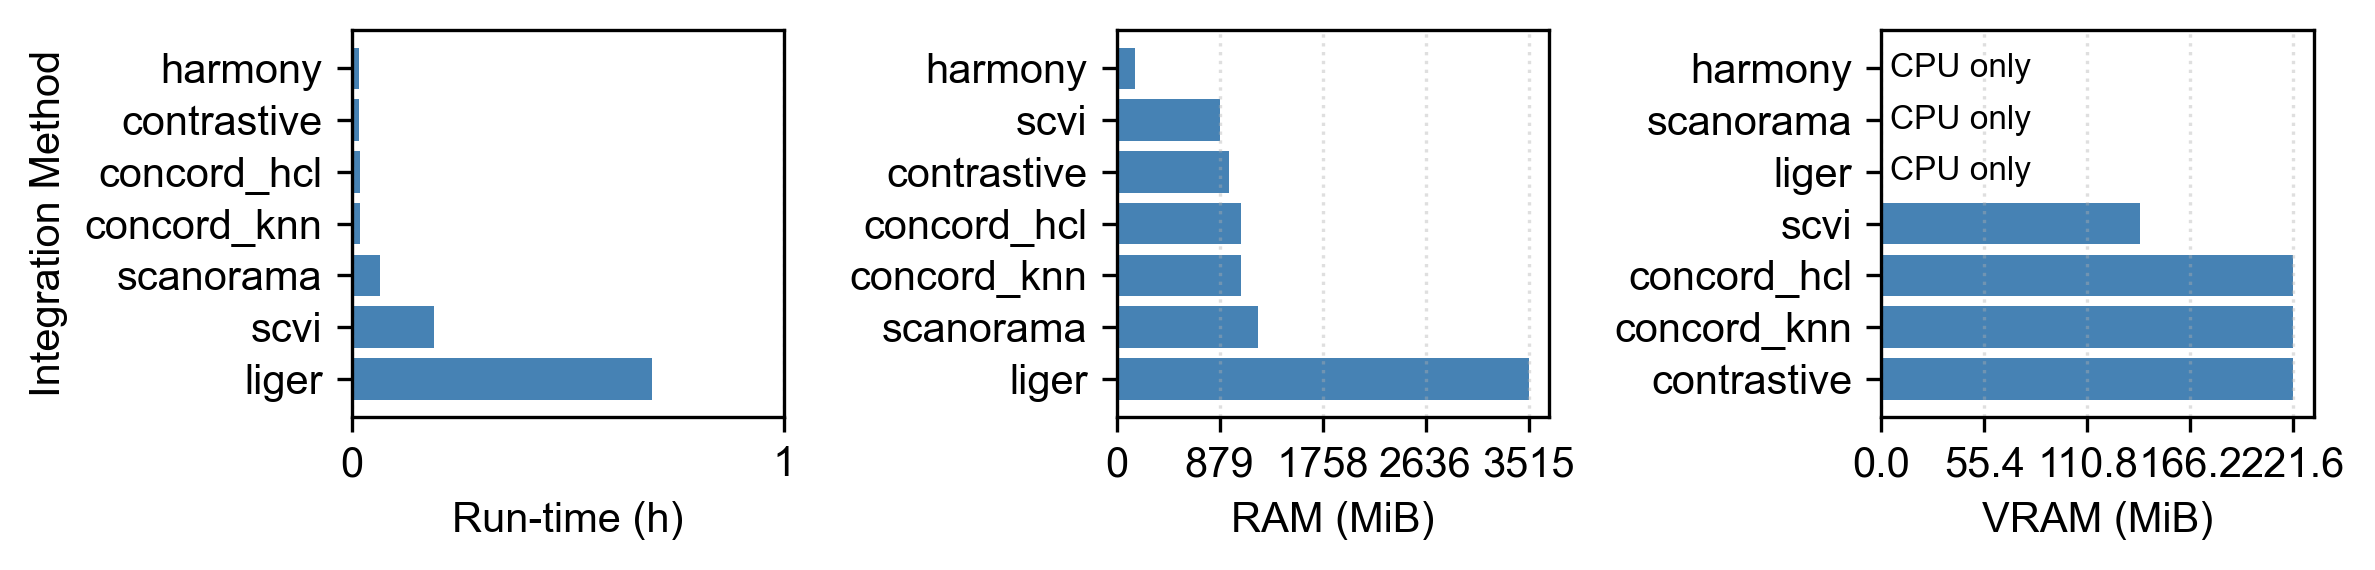

✅ Benchmark summary saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds50_benchmark_summary_Jul09-0033.tsv


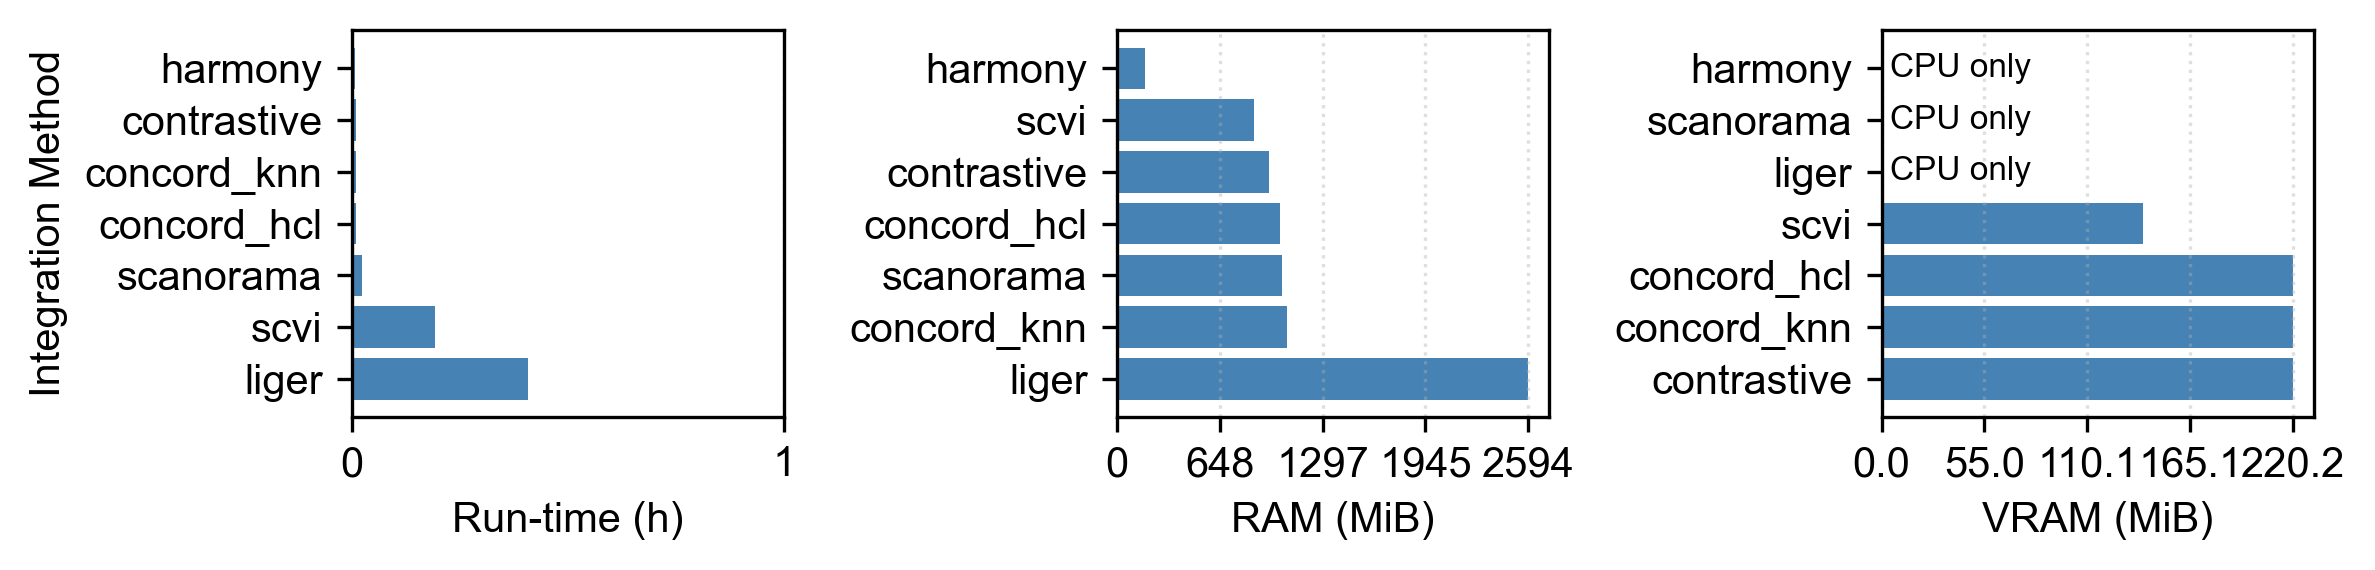

✅ Benchmark summary saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds25_benchmark_summary_Jul09-0033.tsv


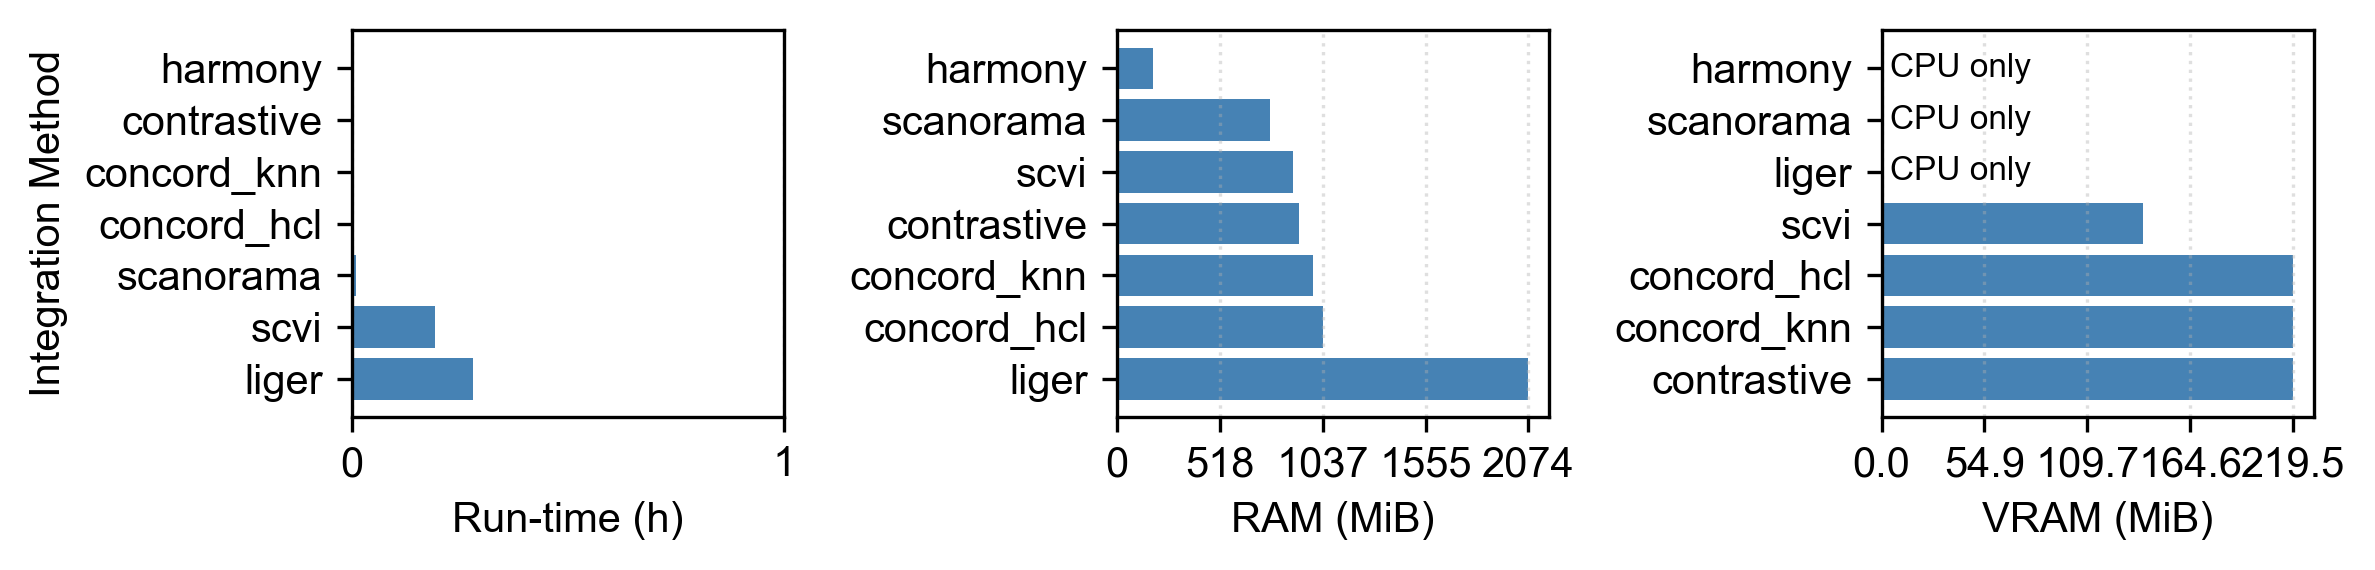

✅ Benchmark summary saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds10_benchmark_summary_Jul09-0033.tsv


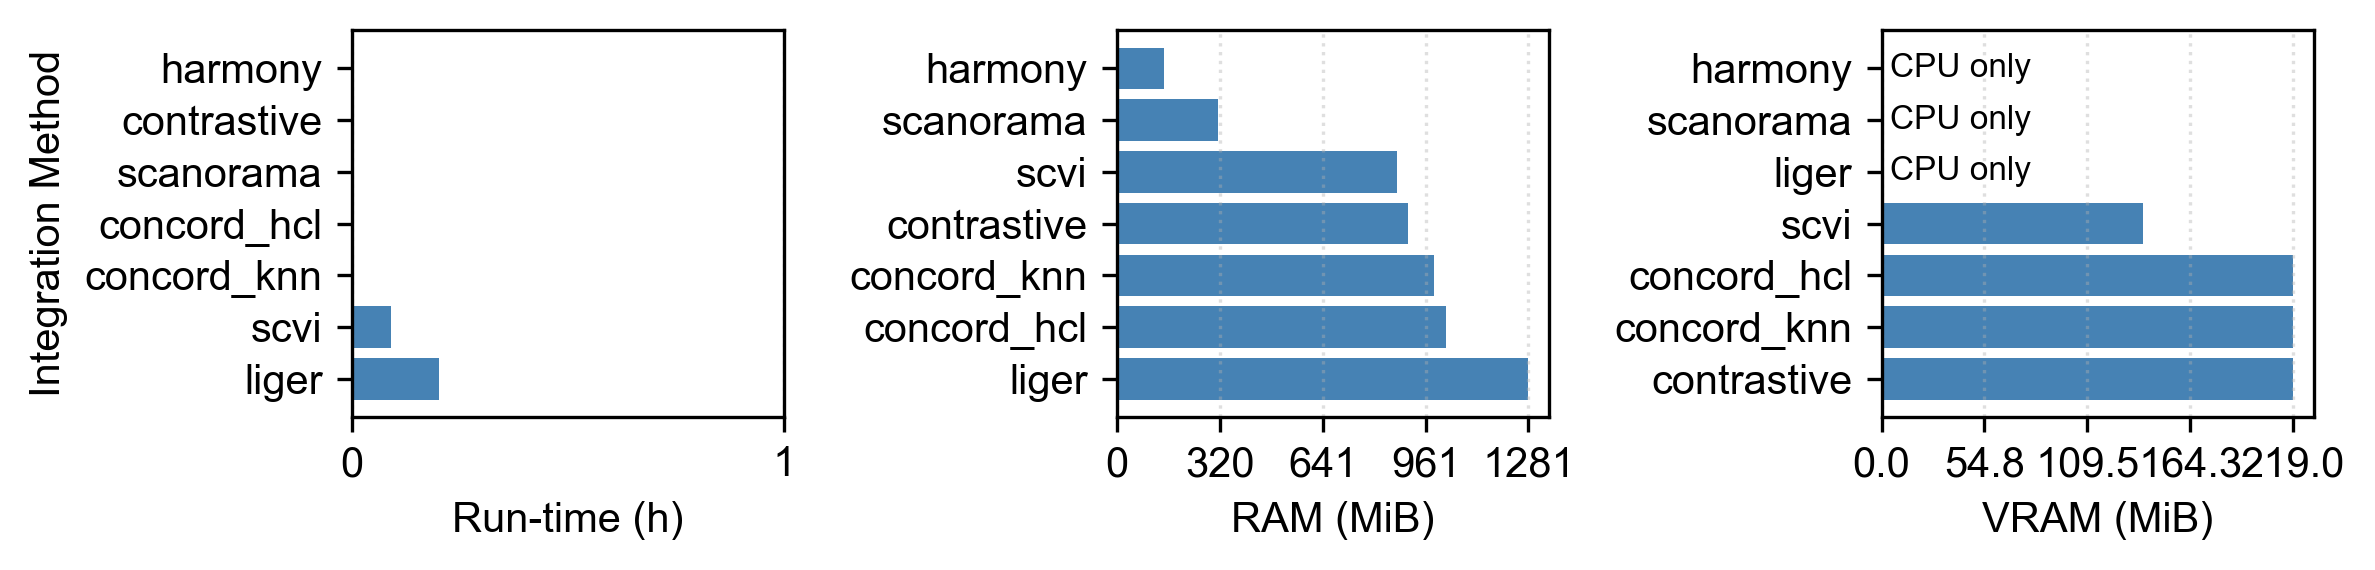

✅ Benchmark summary saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds5_benchmark_summary_Jul09-0033.tsv


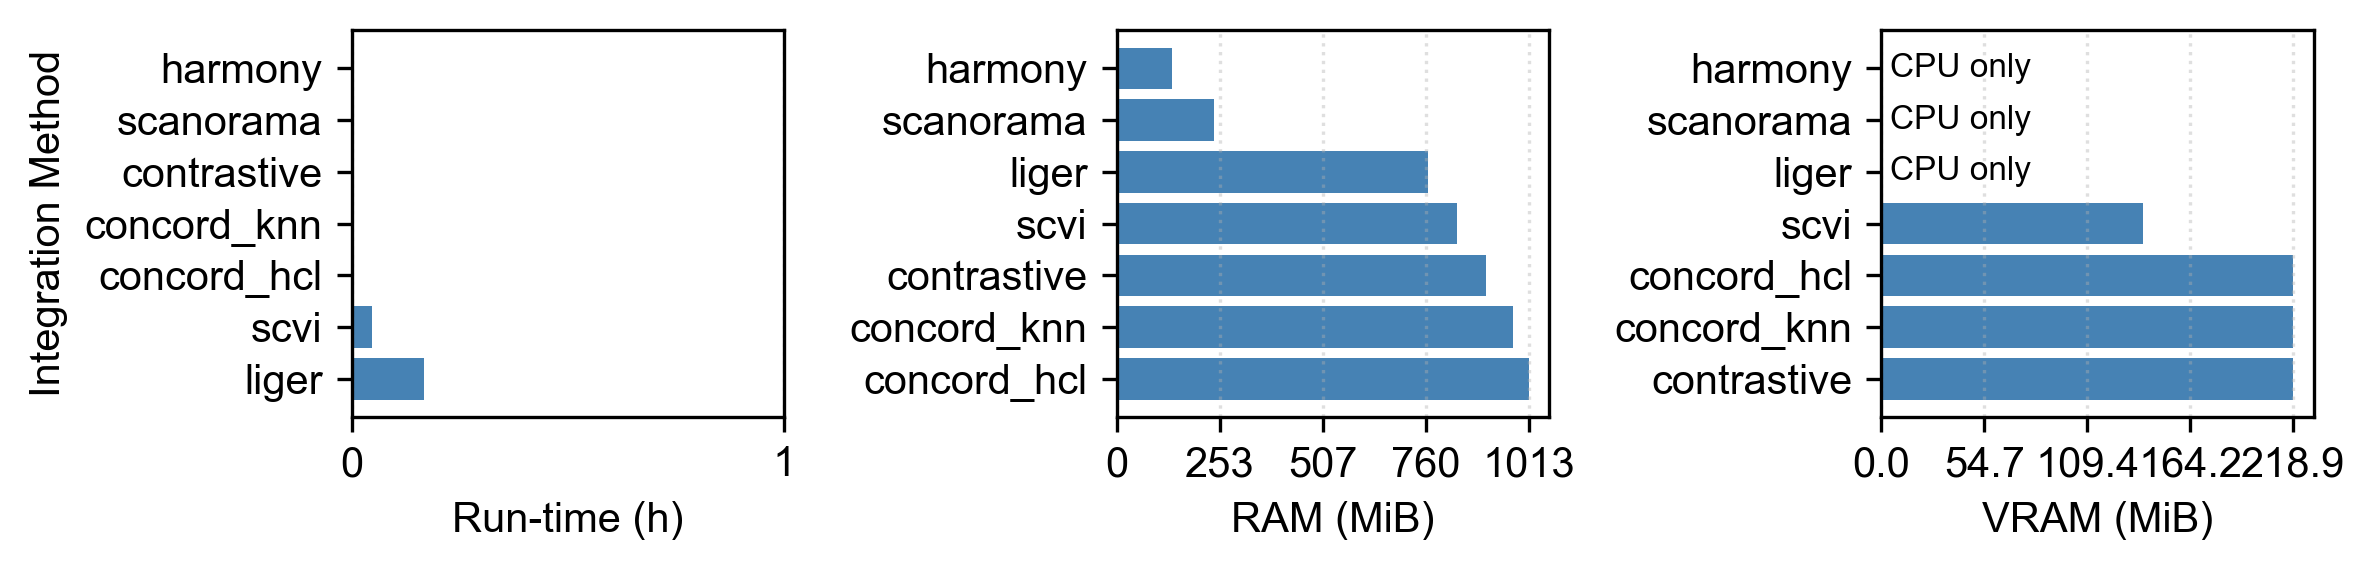

✅ Benchmark summary saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds1_benchmark_summary_Jul09-0033.tsv


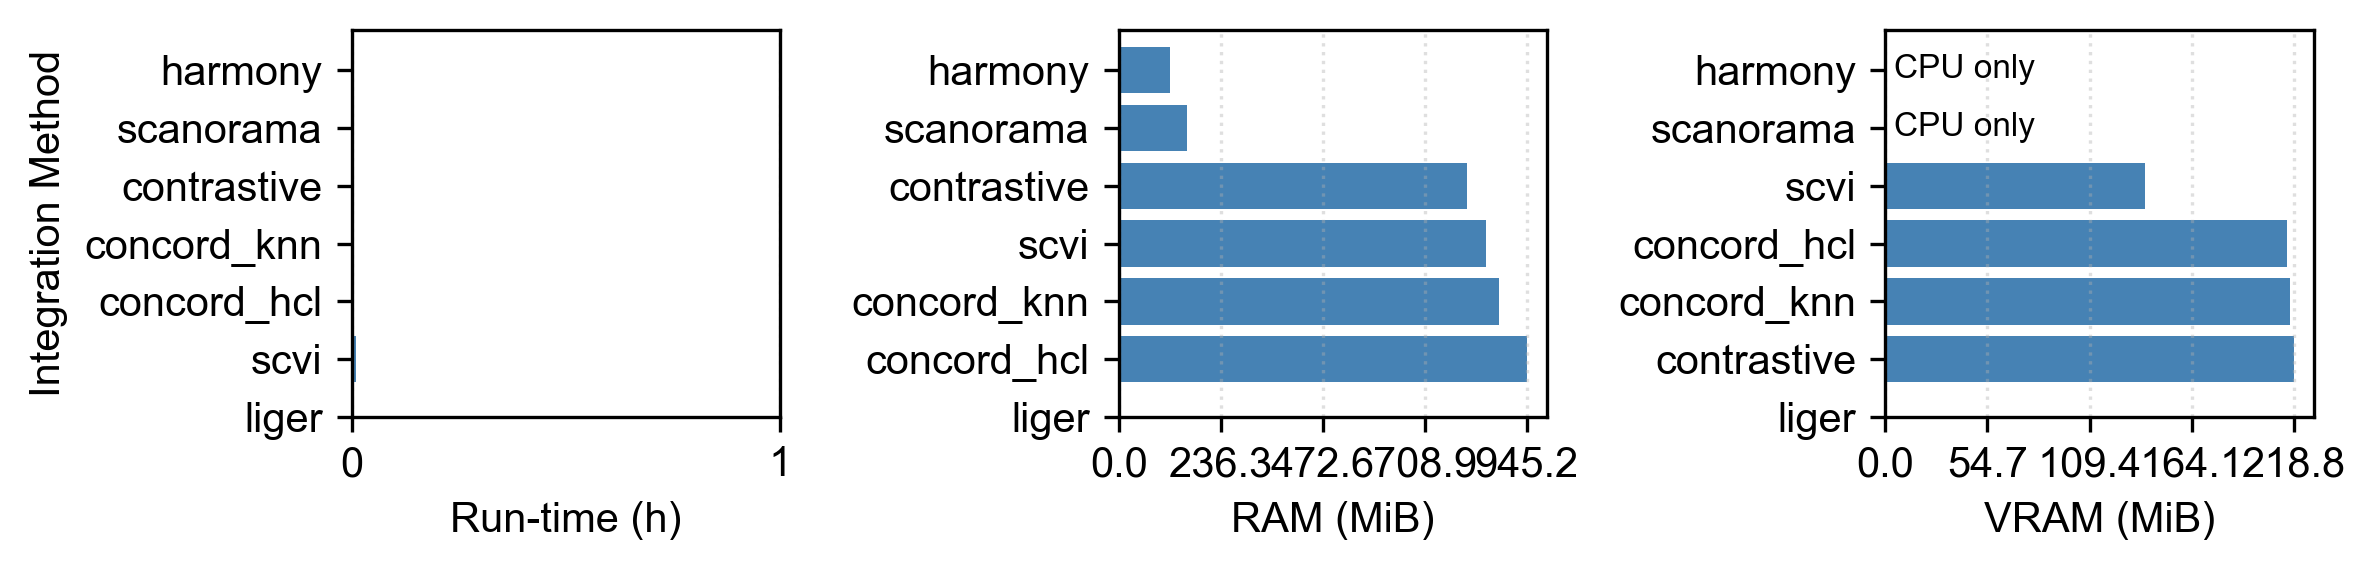

In [6]:
from benchmark_utils import collect_benchmark_logs

for frac in fractions:
    adata_name = f"{file_name}_downsampled_{int(frac * 100)}.h5ad"
    tag        = f"ds{int(frac * 100)}"                   # keeps job names unique
    cur_proj = f"{proj_name}_{tag}"
    bench_df = collect_benchmark_logs(cur_proj, methods)
    # Save the benchmark results
    bench_df.to_csv(save_dir / f"{cur_proj}_benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
    print(f"✅ Benchmark summary saved to: {save_dir / f'{cur_proj}_benchmark_summary_{file_suffix}.tsv'}")
    # Plot benchmark results
    from benchmark_utils import plot_benchmark_performance
    import matplotlib.pyplot as plt
    custom_rc = {
        'font.family': 'Arial',  # Set the desired font for this plot
    }
    with plt.rc_context(rc=custom_rc):
        plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, save_path = save_dir / f"{cur_proj}_benchmark_plot_{file_suffix}.pdf")


#### Benchmark cell type

Filtering cel_packerN2_downsample_ds100 to remove bad annotations: 50590 cells out of 94276
✅ Filtered adata to remove bad annotations, new shape: (43686, 10000)
Cell types: 151, Batches: 7
concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
[KNN] detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for batch with keys ['scvi', 'harmony', '

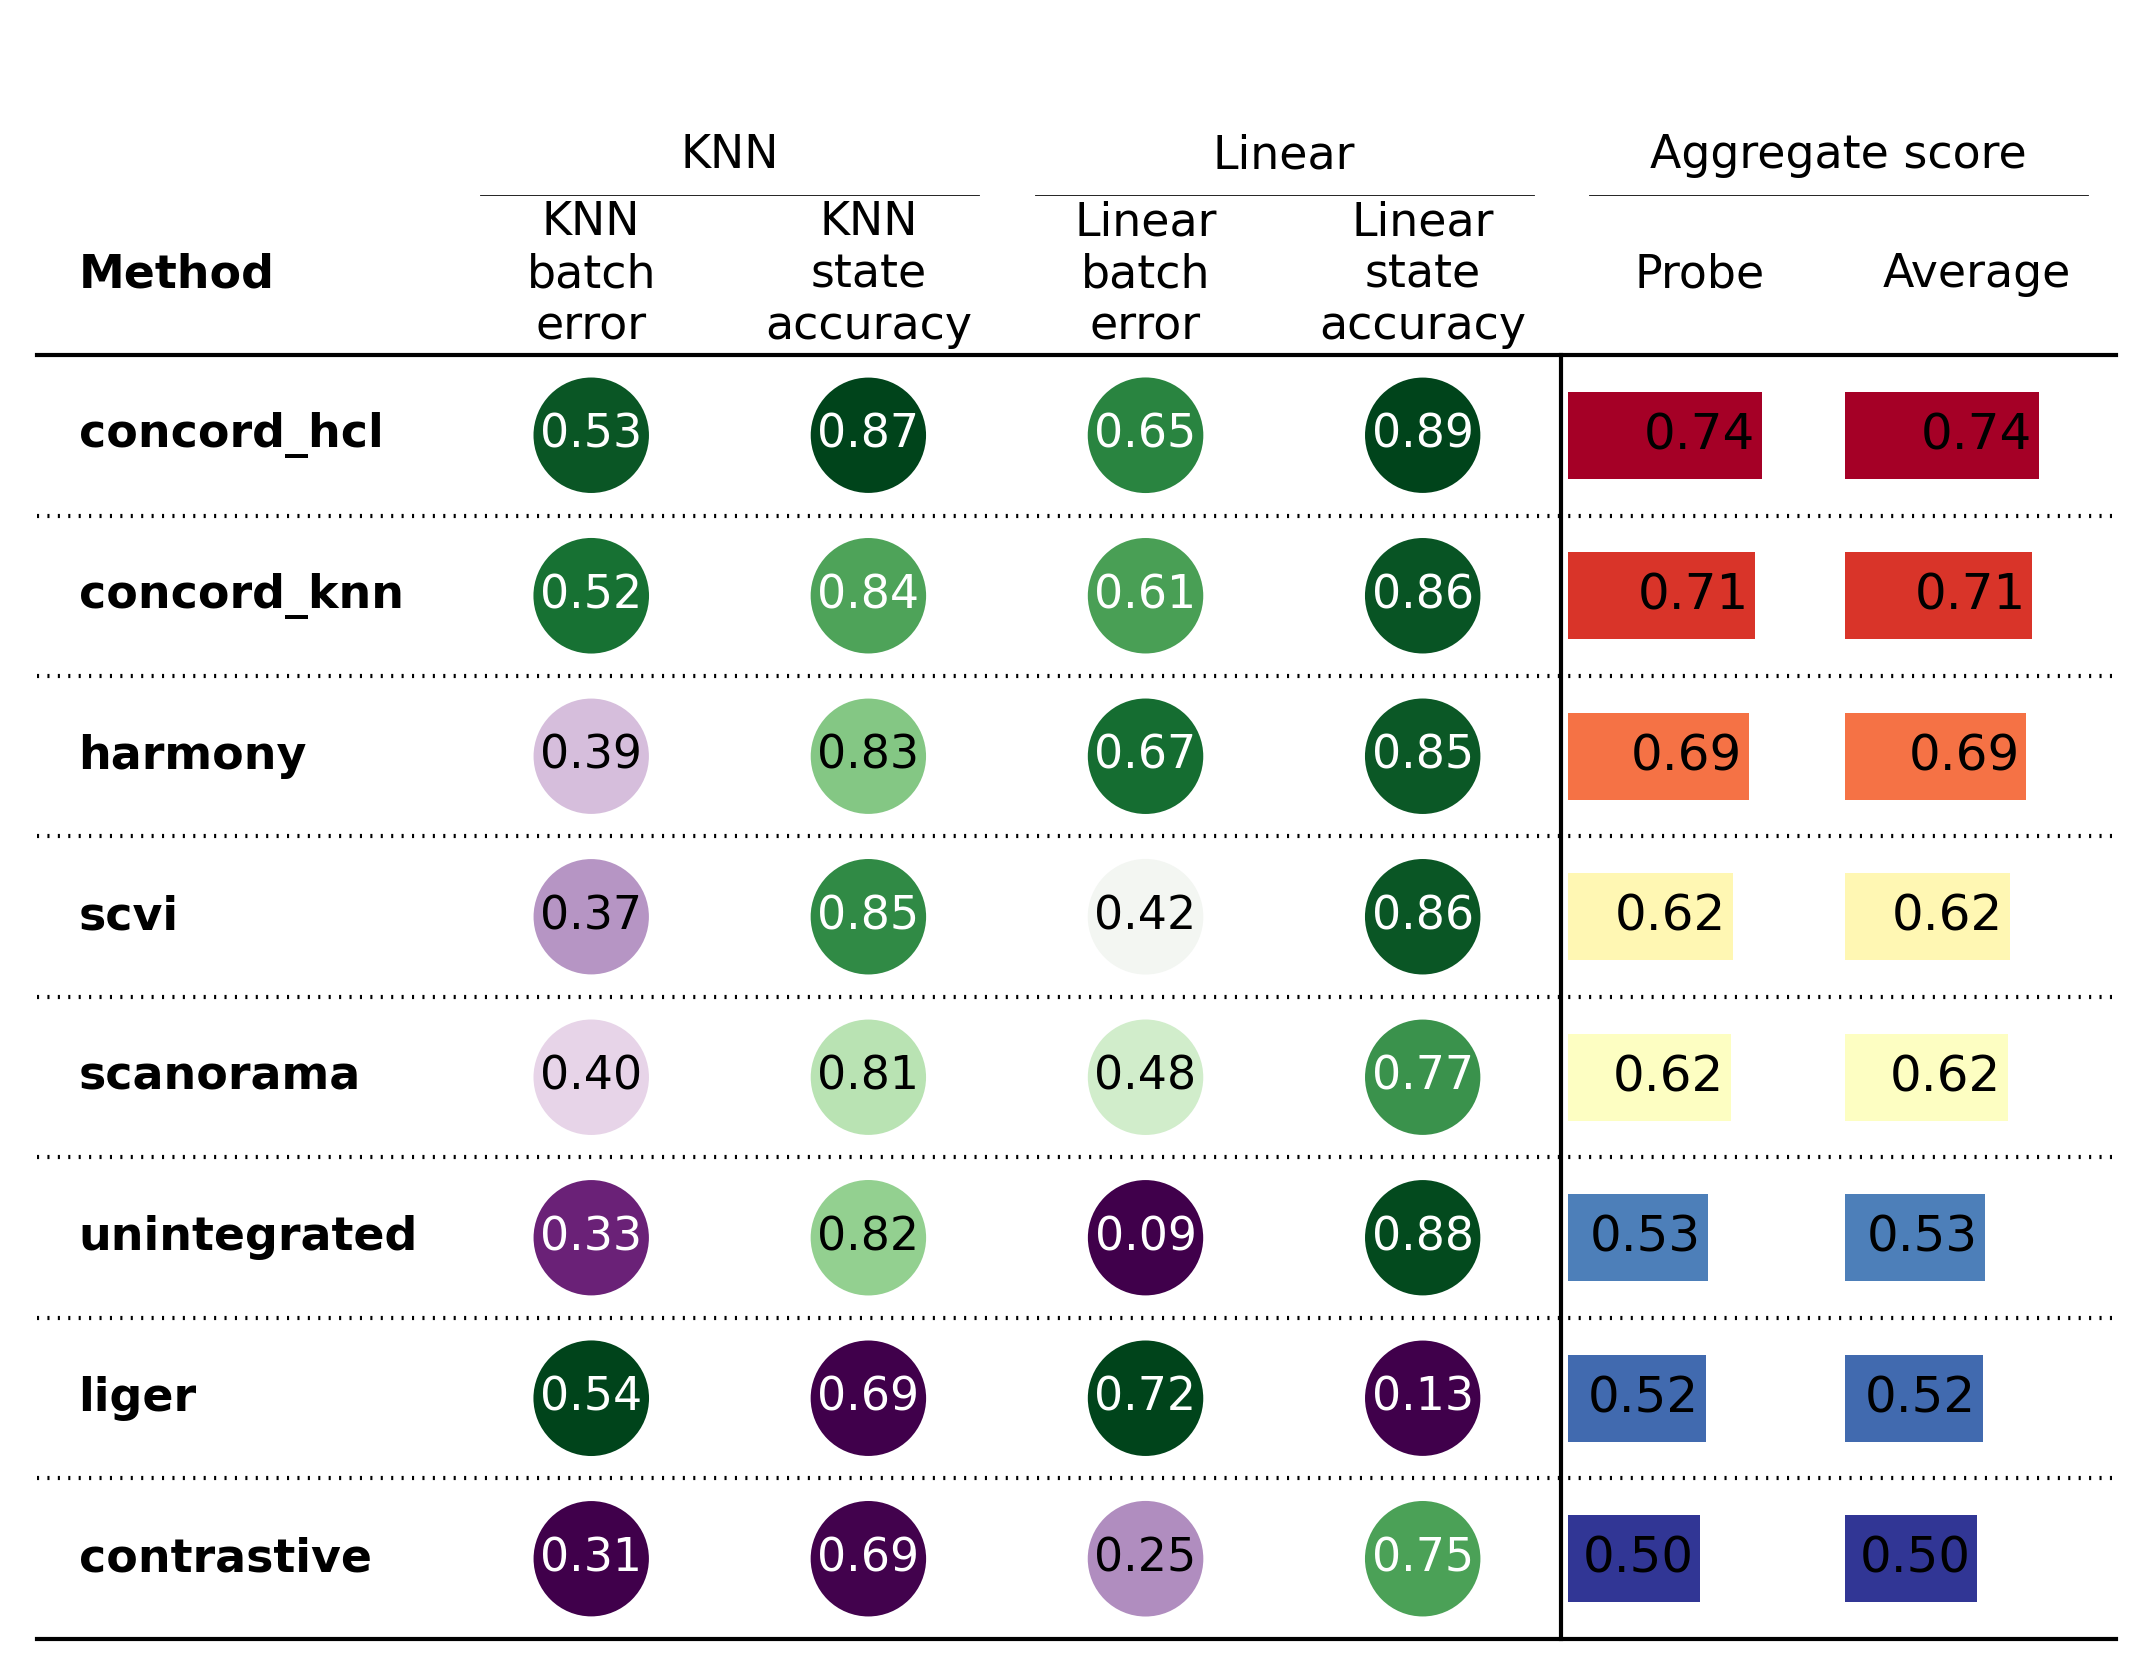

✅ Benchmark results saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds100_benchmark_cell_type_Jul09-0033.pkl
Filtering cel_packerN2_downsample_ds50 to remove bad annotations: 25233 cells out of 47138
✅ Filtered adata to remove bad annotations, new shape: (21905, 10000)
Cell types: 151, Batches: 7
concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
[KNN] dete

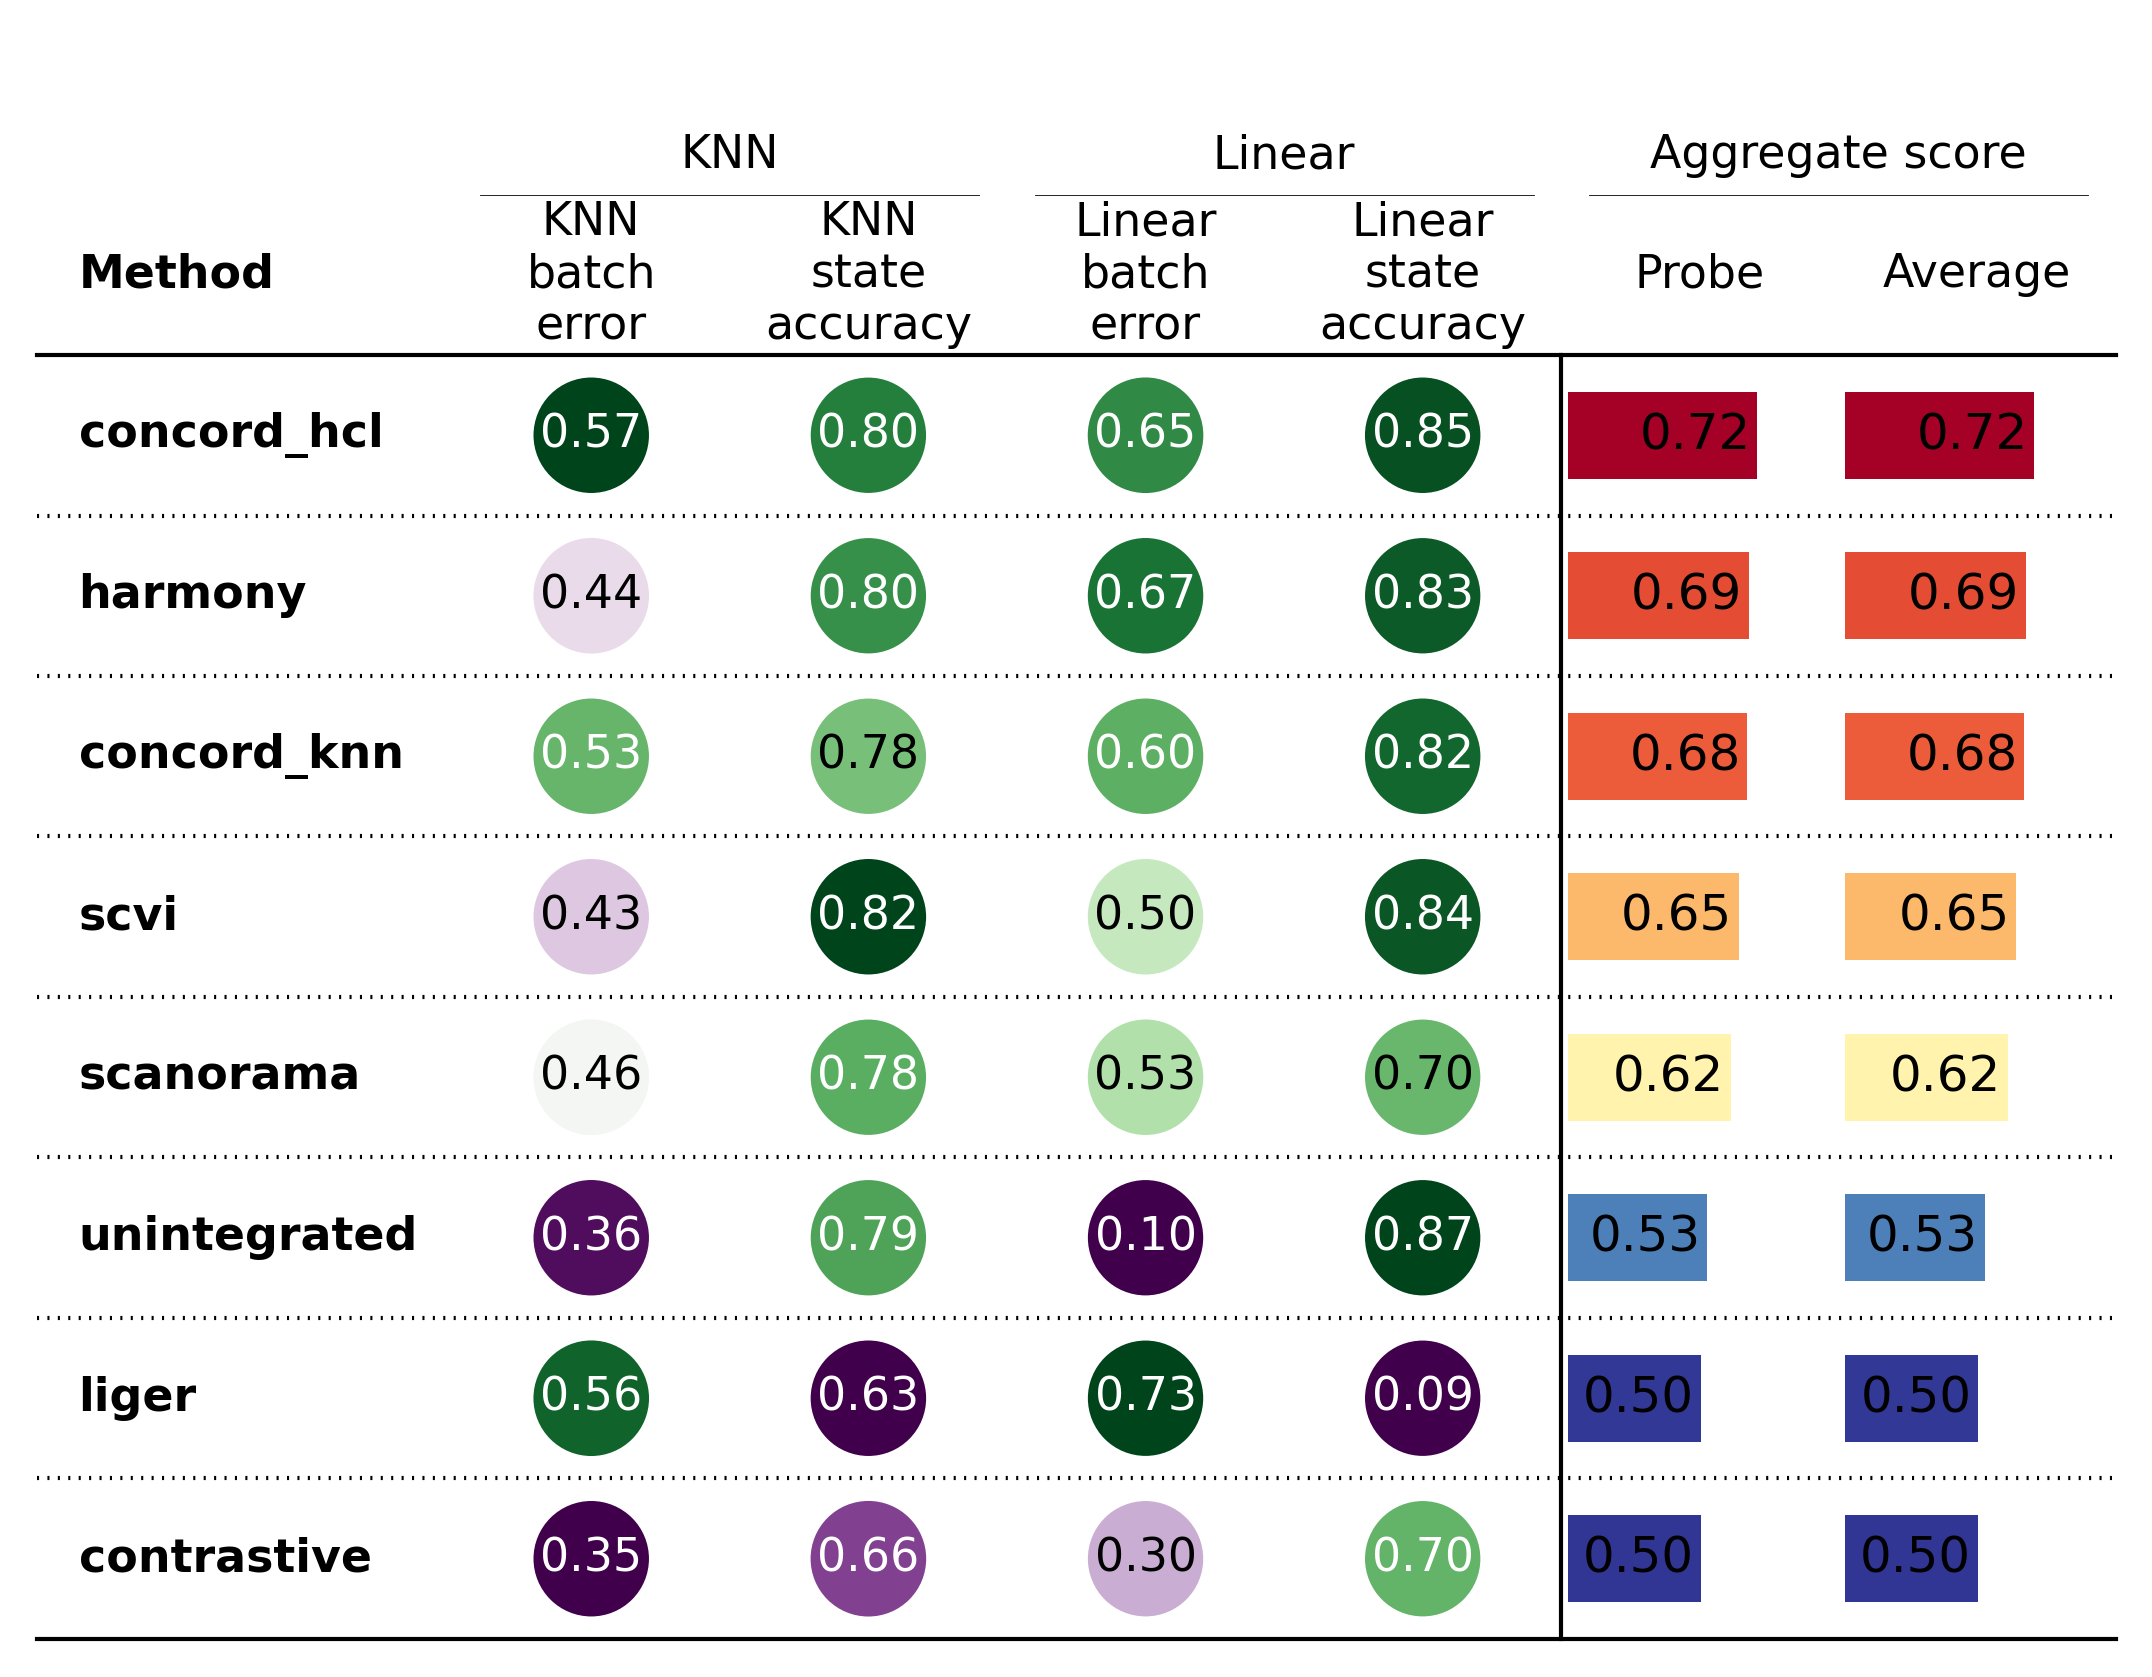

✅ Benchmark results saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds50_benchmark_cell_type_Jul09-0033.pkl
Filtering cel_packerN2_downsample_ds25 to remove bad annotations: 12618 cells out of 23569
✅ Filtered adata to remove bad annotations, new shape: (10951, 10000)
Cell types: 151, Batches: 7
concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
[KNN] detec

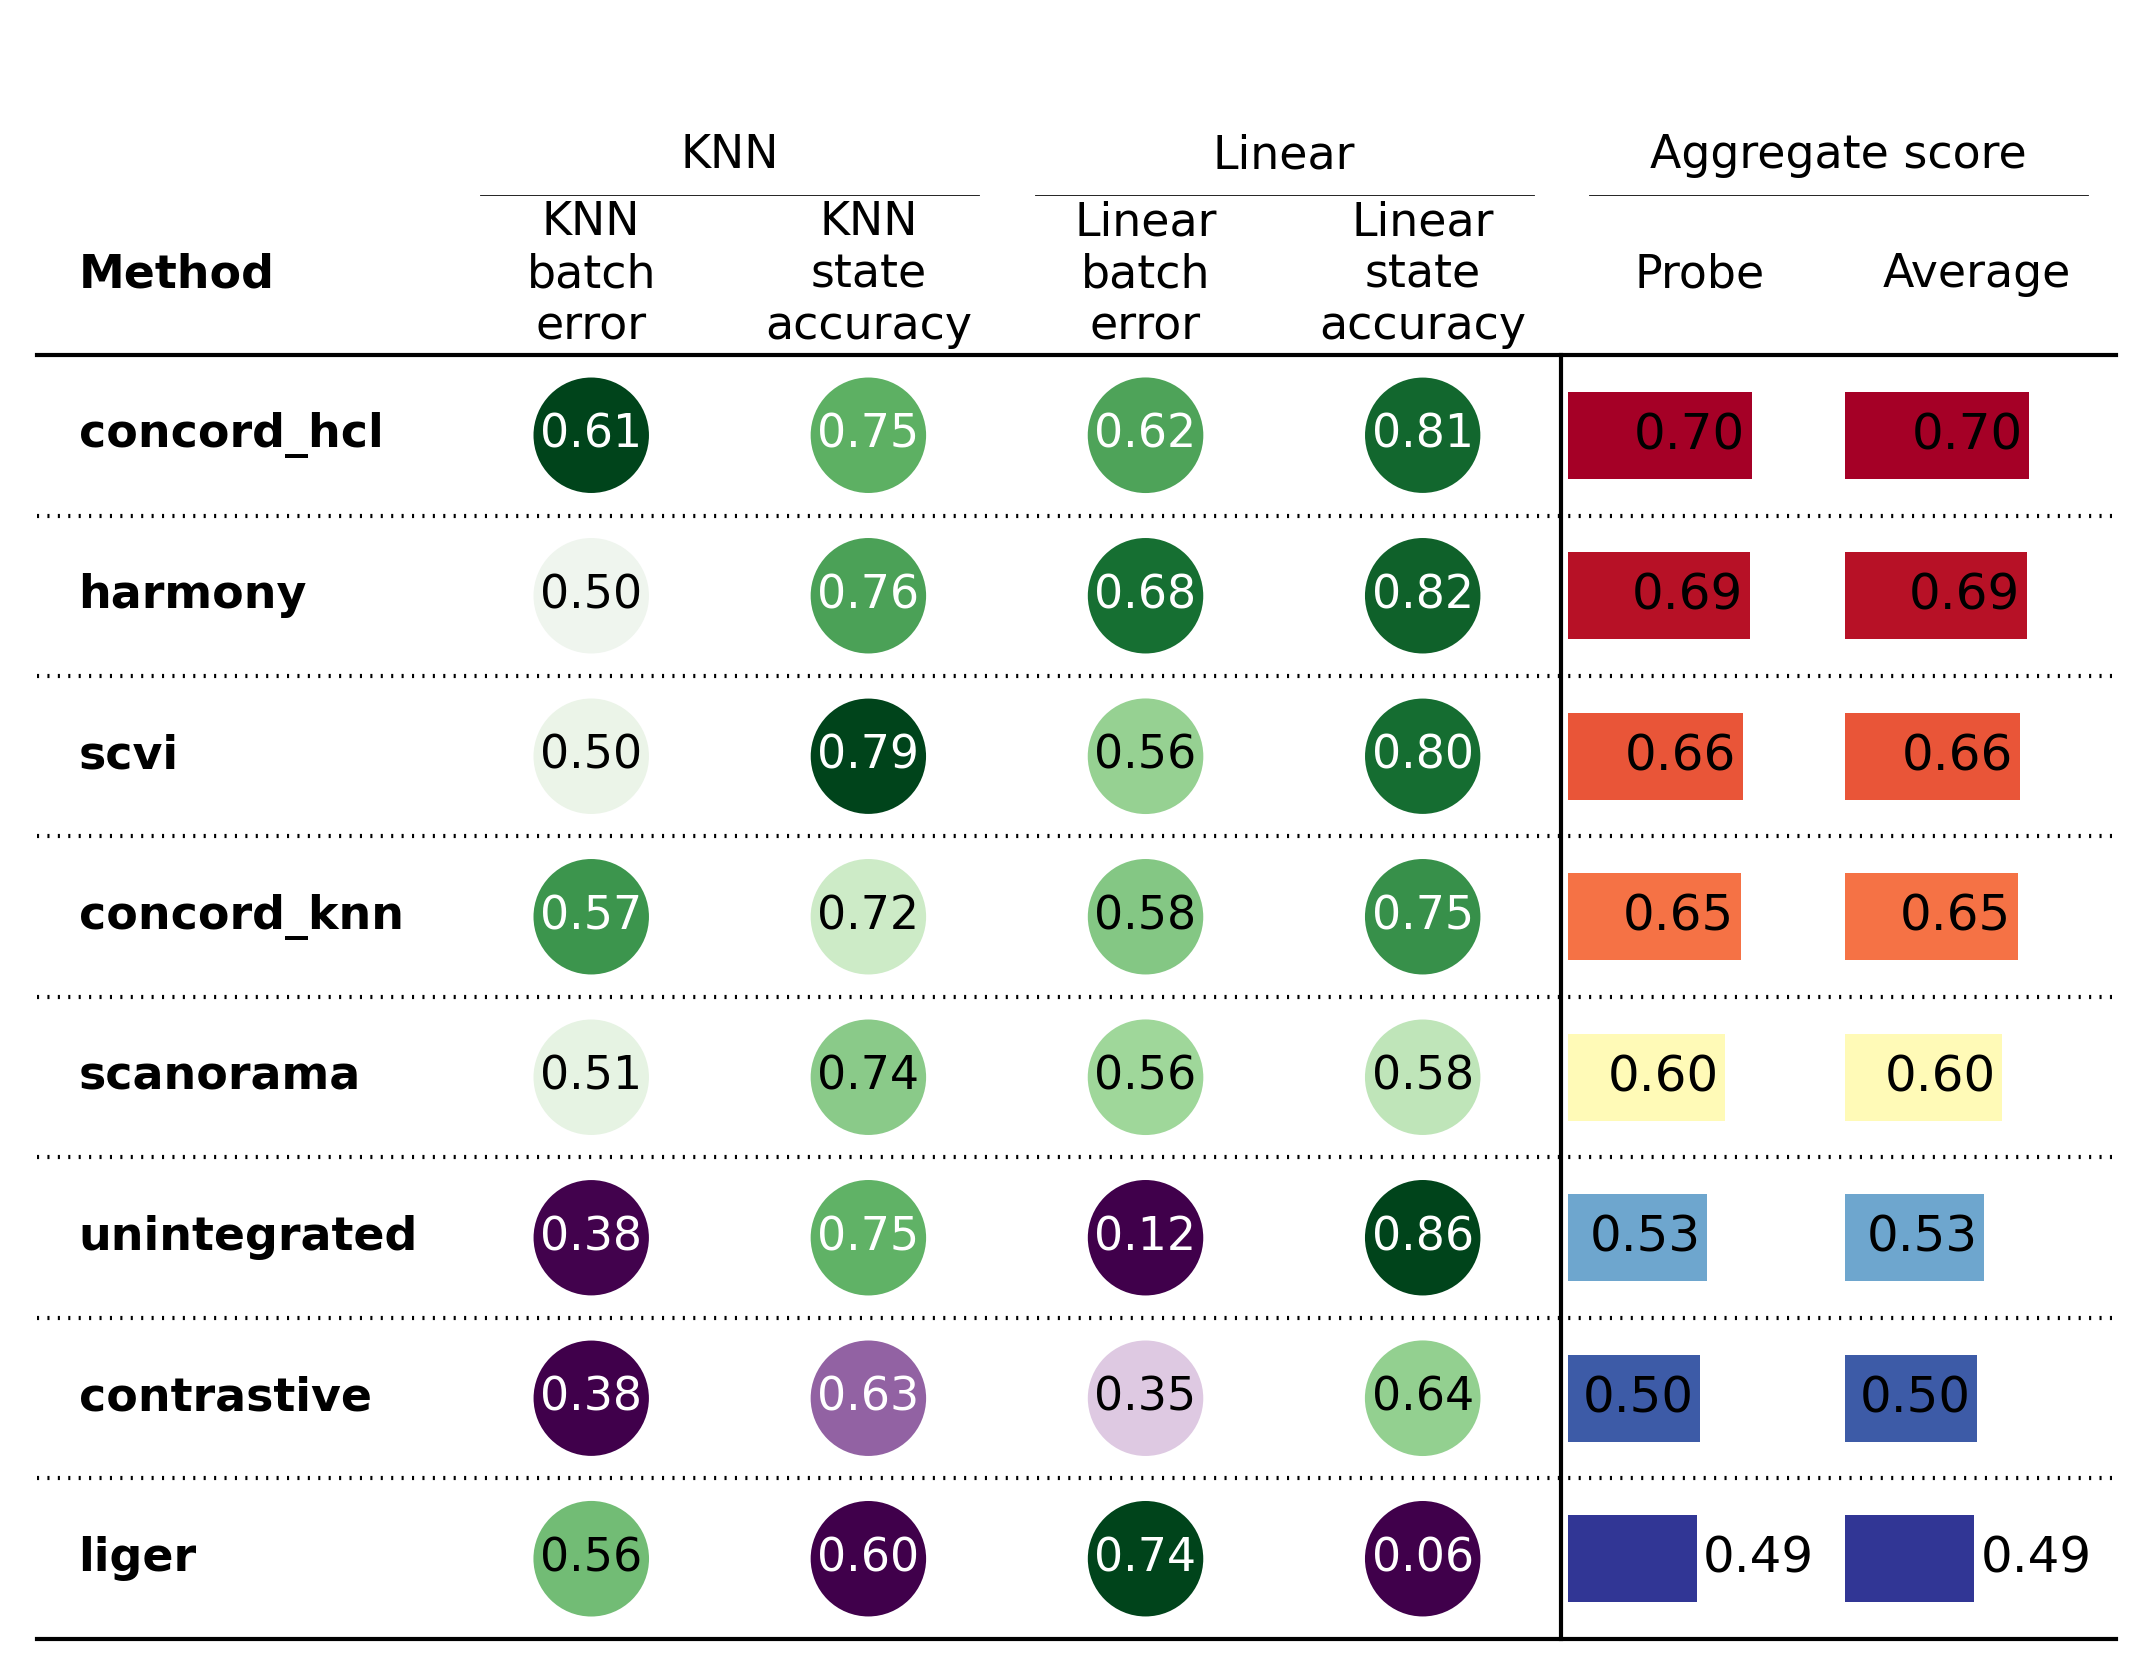

✅ Benchmark results saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds25_benchmark_cell_type_Jul09-0033.pkl
Filtering cel_packerN2_downsample_ds10 to remove bad annotations: 5005 cells out of 9428
✅ Filtered adata to remove bad annotations, new shape: (4423, 10000)
Cell types: 148, Batches: 7
concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
[KNN] detected

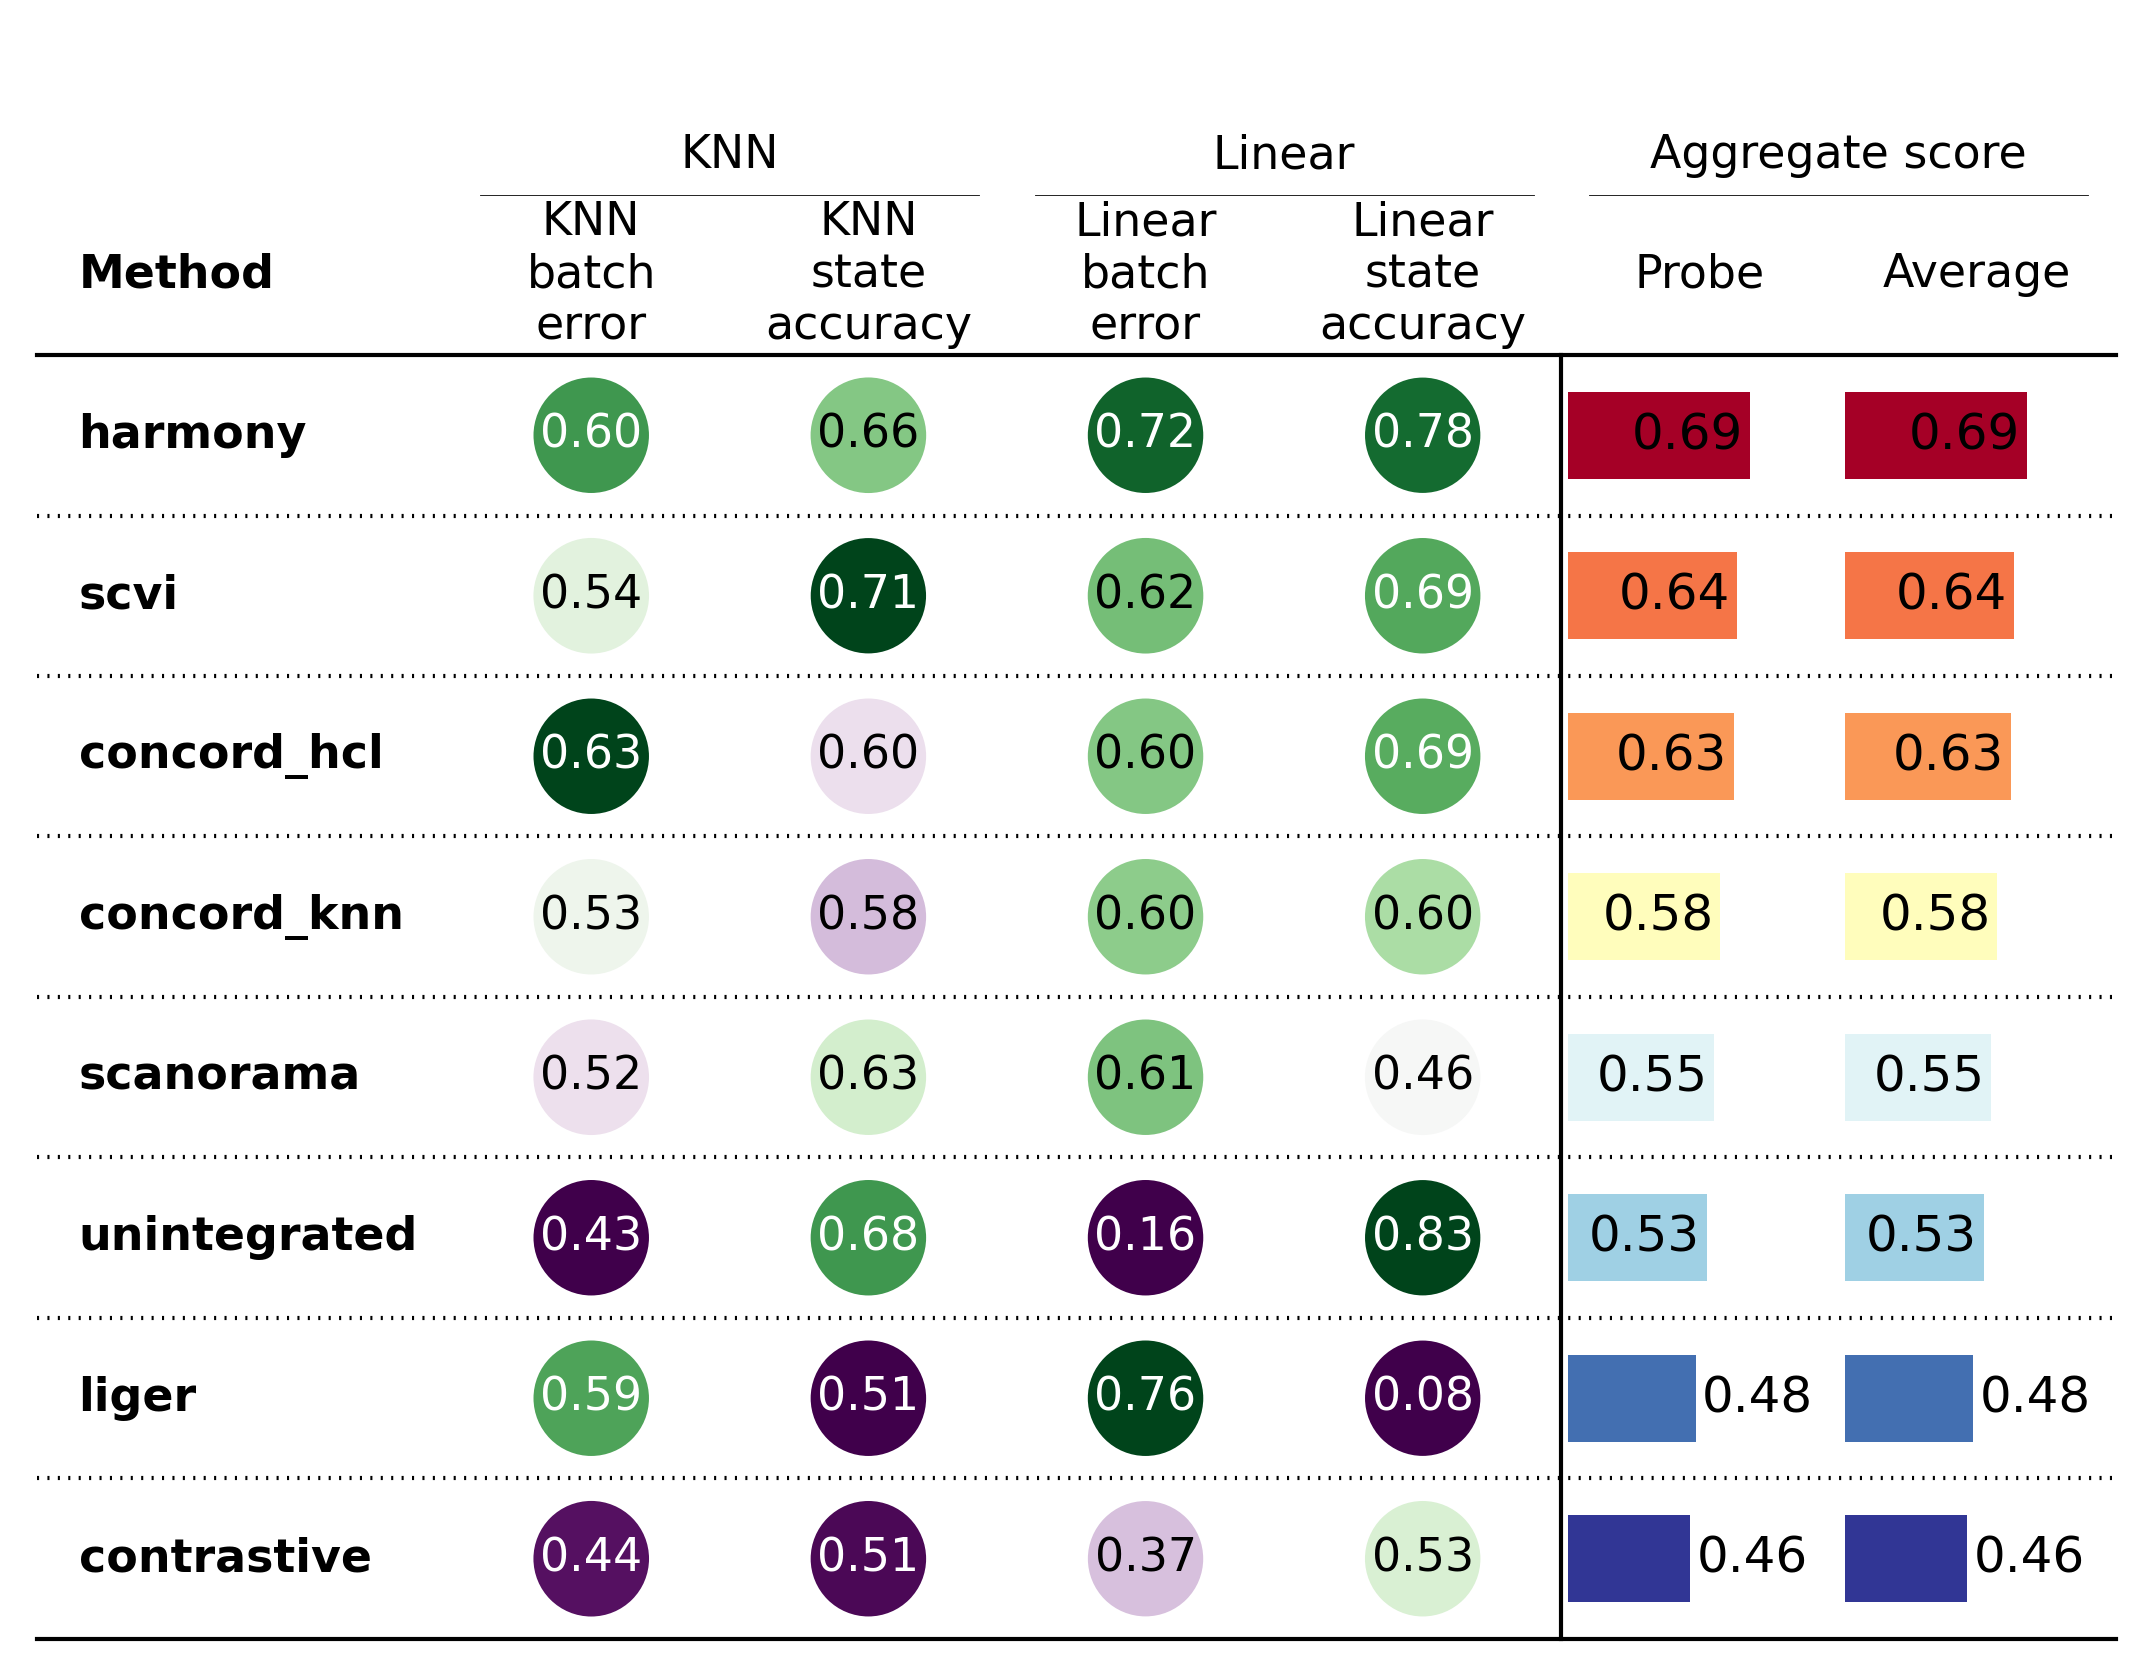

✅ Benchmark results saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds10_benchmark_cell_type_Jul09-0033.pkl
Filtering cel_packerN2_downsample_ds5 to remove bad annotations: 2522 cells out of 4714
✅ Filtered adata to remove bad annotations, new shape: (2192, 10000)
Cell types: 143, Batches: 7
concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running linear probe for batch with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification
concord.benchmarking.benchmark - INFO - Running k-NN probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
[KNN] detected 

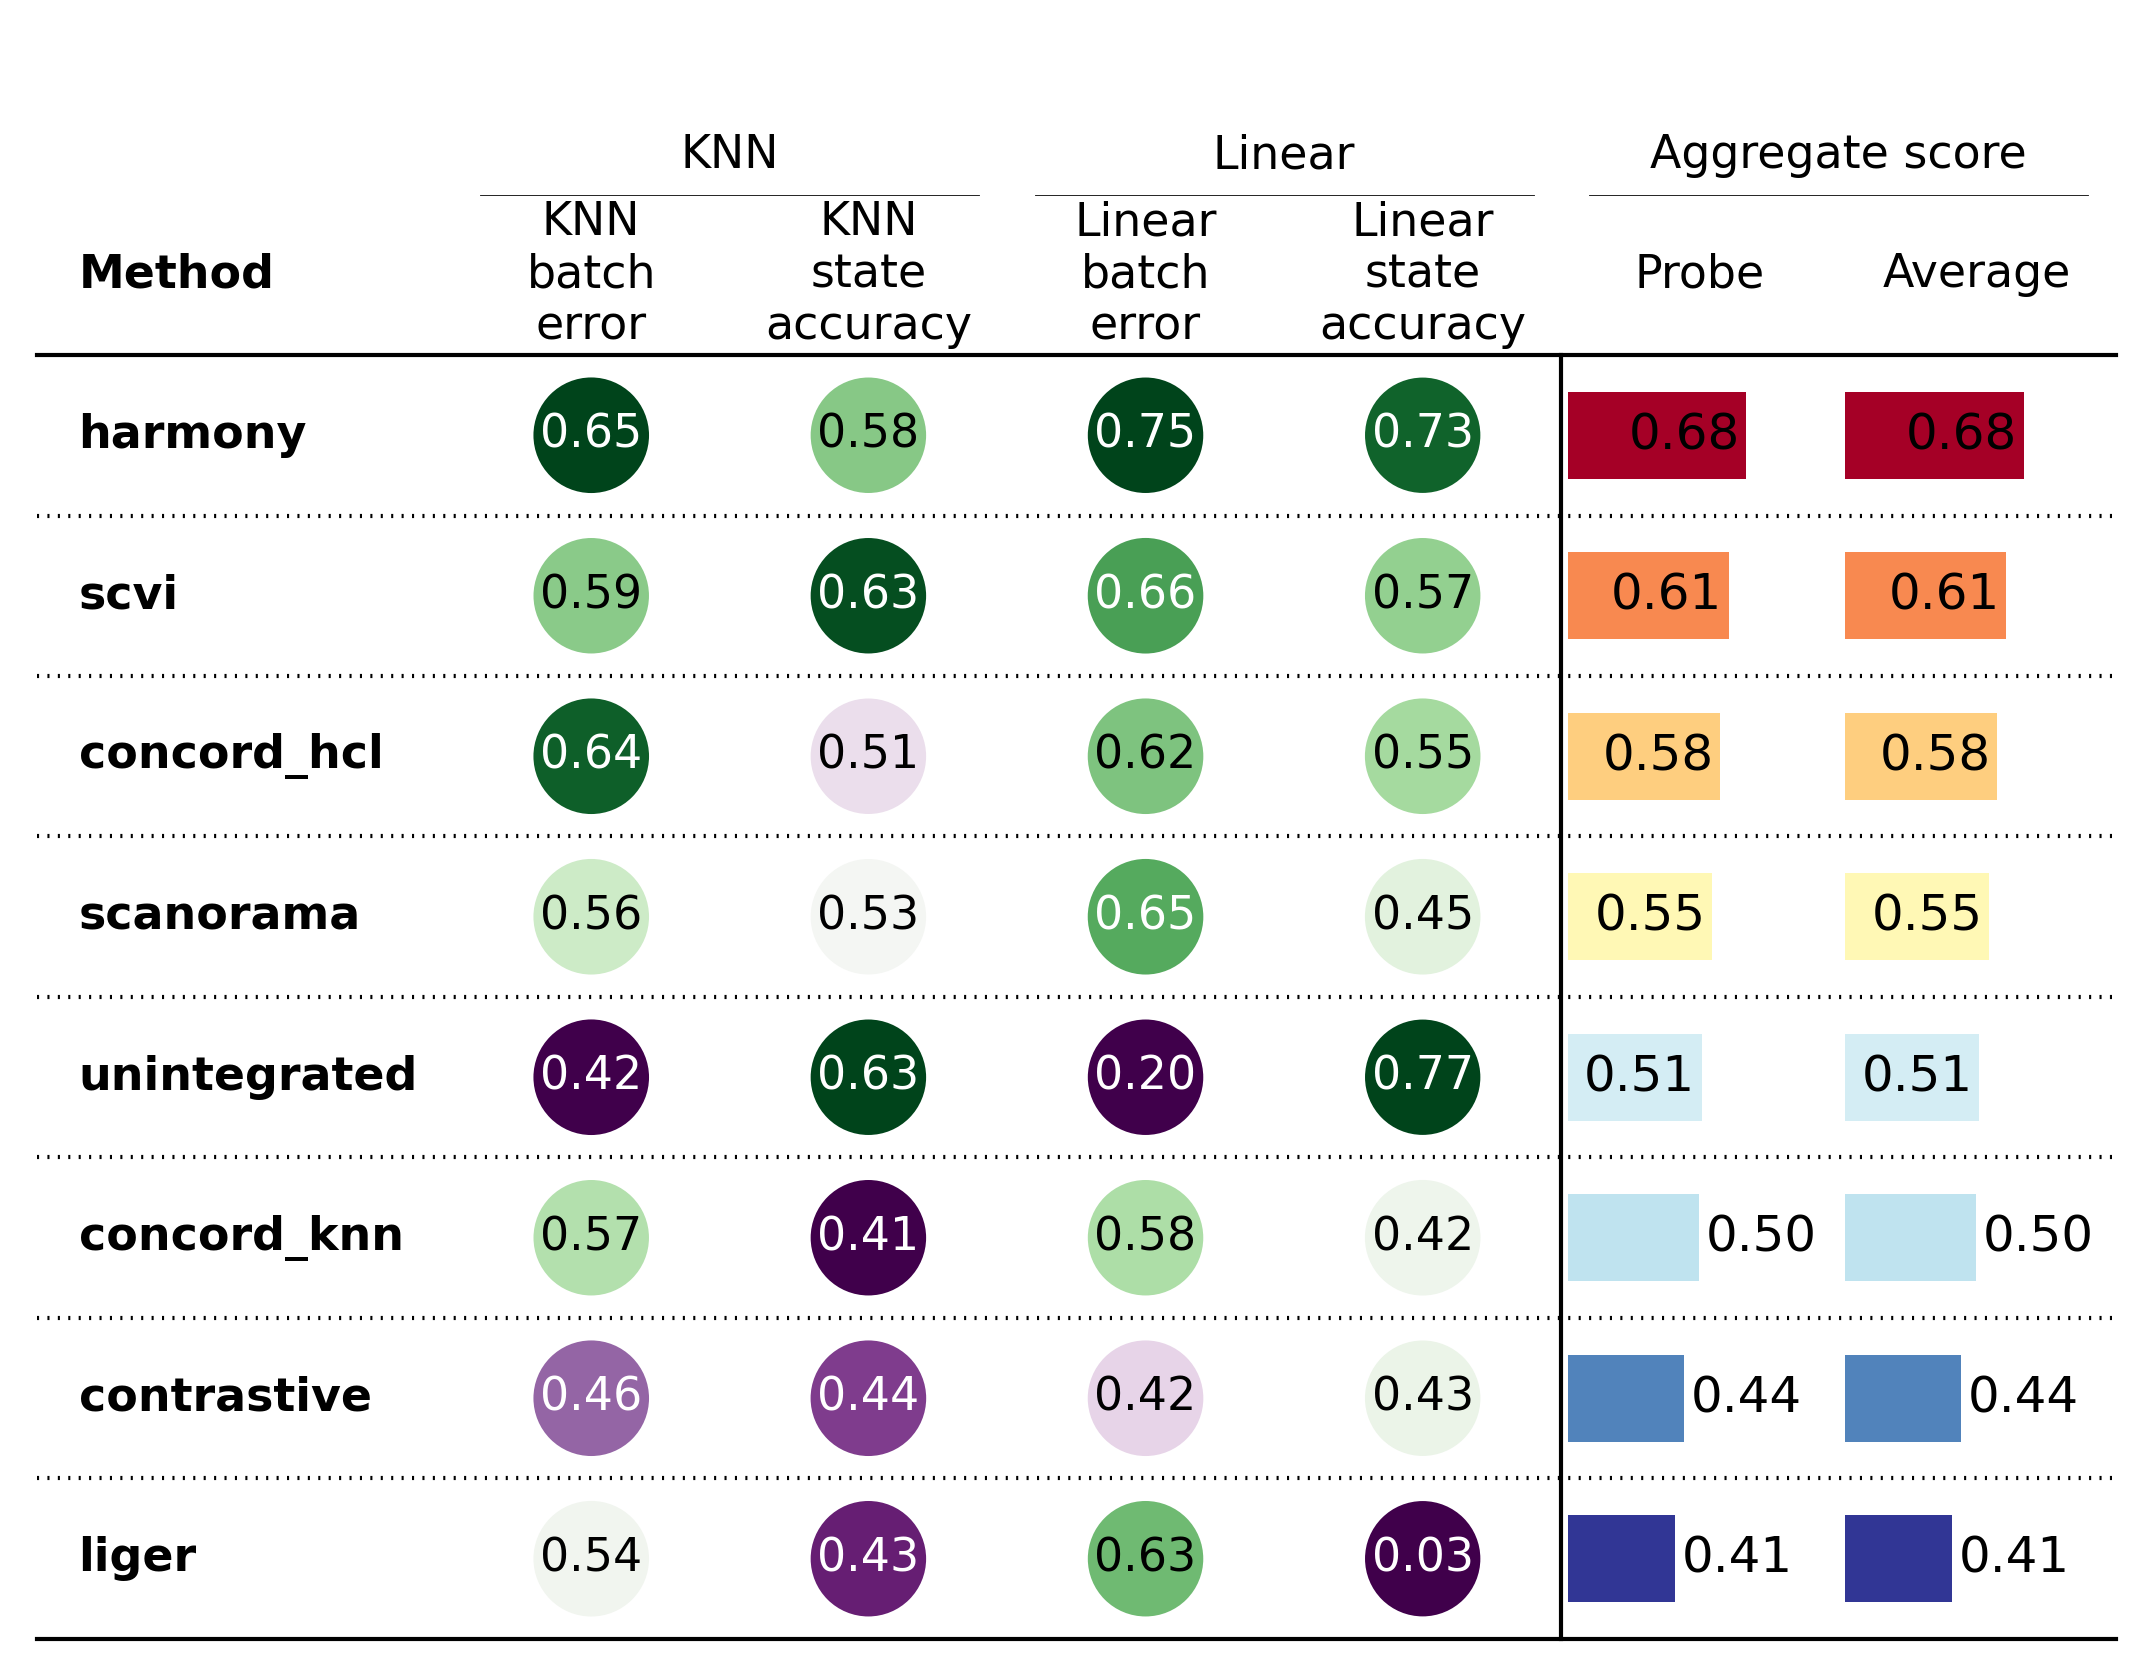

✅ Benchmark results saved to: ../save/cel_packerN2_downsample/cel_packerN2_downsample_ds5_benchmark_cell_type_Jul09-0033.pkl
Filtering cel_packerN2_downsample_ds1 to remove bad annotations: 513 cells out of 943
✅ Filtered adata to remove bad annotations, new shape: (430, 10000)
Cell types: 109, Batches: 7
concord.benchmarking.benchmark - INFO - Running Probe benchmark
concord.benchmarking.benchmark - INFO - Running linear probe for state with keys ['scvi', 'harmony', 'scanorama', 'liger', 'unintegrated', 'concord_hcl', 'concord_knn', 'contrastive']
Detected task: classification


KeyError: 'liger'

In [7]:
import numpy as np
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']

state_benchmarks = {}
for frac in fractions:  # reverse order to process larger fractions first
    adata_name = f"{file_name}_downsampled_{int(frac * 100)}_final.h5ad"
    tag        = f"ds{int(frac * 100)}"                   # keeps job names unique
    cur_proj = f"{proj_name}_{tag}"
    cur_dir = Path("../data") / cur_proj
    cur_adata = sc.read_h5ad(cur_dir / adata_name)
    bad_cells = cur_adata.obs['cell_type'].isin(bad_annotation)
    # Also remove cells with classes with less than 2 cells
    # cell_counts = cur_adata.obs['cell_type'].value_counts()
    # bad_cells |= cur_adata.obs['cell_type'].isin(cell_counts[cell_counts < 3].index)

    print(f"Filtering {cur_proj} to remove bad annotations: {bad_cells.sum()} cells out of {len(cur_adata)}")
    adata_ct = cur_adata[~bad_cells].copy()

    print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_ct.shape}")
    state_counts = len(adata_ct.obs['cell_type'].value_counts())
    batch_counts = len(adata_ct.obs['batch'].value_counts())
    print(f"Cell types: {state_counts}, Batches: {batch_counts}")
    state_key = 'cell_type' if state_counts > 1 else None
    batch_key = 'batch' if batch_counts > 1 else None
    out = ccd.bm.run_benchmark_pipeline(
        adata_ct,
        embedding_keys=methods,
        state_key=state_key,
        batch_key=batch_key,
        save_dir=save_dir / f"{cur_proj}_benchmarks_{state_key}",
        file_suffix=file_suffix,  # e.g. "2025-06-25"
        run=("probe"),          # run only these blocks
        plot_individual=False,          # skip the intermediate PDFs
    )
    combined_celltype = out["combined"]
    state_benchmarks[tag] = combined_celltype

    # Save the benchmark results
    import pickle
    with open(save_dir / f"{cur_proj}_benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
        pickle.dump(out, f)
    print(f"✅ Benchmark results saved to: {save_dir / f'{cur_proj}_benchmark_{state_key}_{file_suffix}.pkl'}")

with open(save_dir / f"{proj_name}_{state_key}_benchmarks_{file_suffix}.pkl", "wb") as f:
    pickle.dump(state_benchmarks, f)
print(f"✅ State benchmarks saved to: {save_dir / f'{proj_name}_{state_key}_benchmarks_{file_suffix}.pkl'}")

#### Benchmark lineage

In [ ]:
import numpy as np
bad_annotation = [np.nan, '', 'unknown', 'None', 'nan', 'NaN', 'NA', 'na', 'unannotated']

state_benchmarks = {}
for frac in fractions:  # reverse order to process larger fractions first
    adata_name = f"{file_name}_downsampled_{int(frac * 100)}_final.h5ad"
    tag        = f"ds{int(frac * 100)}"                   # keeps job names unique
    cur_proj = f"{proj_name}_{tag}"
    cur_dir = Path("../data") / cur_proj
    cur_adata = sc.read_h5ad(cur_dir / adata_name)
    bad_cells = cur_adata.obs['lineage_complete'].isin(bad_annotation)

    print(f"Filtering {cur_proj} to remove bad annotations: {bad_cells.sum()} cells out of {len(cur_adata)}")
    adata_ct = cur_adata[~bad_cells].copy()

    print(f"✅ Filtered adata to remove bad annotations, new shape: {adata_ct.shape}")
    state_counts = len(adata_ct.obs['lineage_complete'].value_counts())
    batch_counts = len(adata_ct.obs['batch'].value_counts())
    print(f"Cell types: {state_counts}, Batches: {batch_counts}")
    state_key = 'lineage_complete' if state_counts > 1 else None
    batch_key = 'batch' if batch_counts > 1 else None
    out = ccd.bm.run_benchmark_pipeline(
        adata_ct,
        embedding_keys=methods,
        state_key=state_key,
        batch_key=batch_key,
        save_dir=save_dir / f"{cur_proj}_benchmarks_{state_key}",
        file_suffix=file_suffix,  # e.g. "2025-06-25"
        run=("probe"),          # run only these blocks
        plot_individual=False,          # skip the intermediate PDFs
    )
    combined_celltype = out["combined"]
    state_benchmarks[tag] = combined_celltype

    # Save the benchmark results
    import pickle
    with open(save_dir / f"{cur_proj}_benchmark_{state_key}_{file_suffix}.pkl", "wb") as f:
        pickle.dump(out, f)
    print(f"✅ Benchmark results saved to: {save_dir / f'{cur_proj}_benchmark_{state_key}_{file_suffix}.pkl'}")

with open(save_dir / f"{proj_name}_{state_key}_benchmarks_{file_suffix}.pkl", "wb") as f:
    pickle.dump(state_benchmarks, f)
print(f"✅ State benchmarks saved to: {save_dir / f'{proj_name}_{state_key}_benchmarks_{file_suffix}.pkl'}")